In [2]:
import pandas as pd
import numpy as np
import glob
import re 
from tqdm import tqdm

In [3]:
sales_path = r'C:\SFSU\Spring 2020\Project\Data\salesframe_tagged.csv'
sales_columns = ['number_street_type',
                'Beds',
                'Baths(F)',
                'SqFt',
                'LotSqFt',
                'Year Built',
                'Zip Code',
                'Zoning Text',
                'Stories',
                'long',
                'lat',
                'Sale Price',
                'Status Change Date',
                'PropType']

sales_out = pd.read_csv(sales_path, usecols= sales_columns, parse_dates=['Status Change Date', 'Year Built'])

In [4]:
sales_out['Year Built'] = pd.to_numeric(sales_out['Year Built'], errors='coerce', downcast='integer')

In [5]:
sales_out = sales_out[sales_out['Sale Price']>0]

In [6]:
sales_out['month'] = sales_out['Status Change Date'].dt.month
sales_out['year'] = sales_out['Status Change Date'].dt.year

In [7]:
sales_out.drop(columns=['number_street_type','Status Change Date'], inplace=True)

In [8]:
cat_cols = ['Zip Code','month','year']#,'Zoning Text','month','year','PropType']

In [9]:
sales_out.head()

,long,lat,Beds,Baths(F),SqFt,LotSqFt,PropType,Sale Price,Stories,Year Built,Zip Code,Zoning Text,month,year
1,-122.457174,37.729578,3.0,3.0,2375.0,6686.0,Single Family Home,625000.0,NaN,1920.0,94112.0,NaN,10,1998
2,-122.457174,37.729578,3.0,3.0,2375.0,0.0,Single Family Home,625000.0,1.0,1920.0,94112.0,Other,10,1998
3,-122.457174,37.729578,3.0,2.0,2375.0,0.0,Single Family Home,1318899.0,2.0,1920.0,94112.0,RH-1(D),10,2011
4,-122.393159,37.721722,1.0,1.0,590.0,0.0,Single Family Home,85000.0,NaN,1924.0,94124.0,Other,11,1998
5,-122.393159,37.721722,5.0,3.0,1502.0,2500.0,Single Family Home,820000.0,NaN,1924.0,94124.0,RH-1,8,2018


In [10]:
z_norm = list(sales_out['Zoning Text'].value_counts()[sales_out['Zoning Text'].value_counts()>100].index)
sales_out.loc[~sales_out['Zoning Text'].isin(z_norm),'Zoning Text'] = 'Other'

sales_out['Zoning Text'] = sales_out['Zoning Text'].astype('category')
sales_out['PropType'] = sales_out['PropType'].astype('category')

sales_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185355 entries, 1 to 185847
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   long         185355 non-null  float64 
 1   lat          185355 non-null  float64 
 2   Beds         183222 non-null  float64 
 3   Baths(F)     185271 non-null  float64 
 4   SqFt         185072 non-null  float64 
 5   LotSqFt      184328 non-null  float64 
 6   PropType     185355 non-null  category
 7   Sale Price   185355 non-null  float64 
 8   Stories      47098 non-null   float64 
 9   Year Built   183337 non-null  float64 
 10  Zip Code     180911 non-null  float64 
 11  Zoning Text  185355 non-null  category
 12  month        185355 non-null  int64   
 13  year         185355 non-null  int64   
dtypes: category(2), float64(10), int64(2)
memory usage: 18.7 MB


In [11]:
sales_out2 = sales_out.drop(columns=['PropType','Zoning Text'])

In [11]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = sales_out2.loc[:,sales_out2.columns != 'Sale Price'].copy()
y = sales_out2['Sale Price'].copy()
y = np.log(y)

X_train1, X_valid1, y_train1, y_valid1 = train_test_split( X, y, test_size=0.05, random_state=42)
    
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train1, y_train1, categorical_feature=cat_cols, free_raw_data=False)
lgvalid = lgb.Dataset(X_valid1, y_valid1, categorical_feature=cat_cols, free_raw_data=False)

params = {
    'objective' : 'regression',
    'num_iterations' : 7500,
    'metric' : 'rmse',
    'num_leaves' : 100,#50,
    'max_bin' : 500,#500,
    'max_depth': 50,#15,
    'bagging_fraction' : 0.8,#0.7,
    'bagging_freq' : 10,
    'learning_rate' : 0.05,#0.035,#0.025,#0.013,#0.007,
    'feature_fraction' : 0.75,
    'verbosity' : 0,
    #'subsample': 0.5,
    #'n_estimators': 1400
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(
    params,
    lgtrain,
    valid_sets=[lgtrain, lgvalid],
    valid_names=["train", "valid"],
    early_stopping_rounds=2000,
    verbose_eval=500,
    evals_result=evals_result
)

C:\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 2000 rounds
[500]	train's rmse: 0.138635	valid's rmse: 0.154057
[1000]	train's rmse: 0.117161	valid's rmse: 0.140978
[1500]	train's rmse: 0.102981	valid's rmse: 0.133283
[2000]	train's rmse: 0.0921086	valid's rmse: 0.127854
[2500]	train's rmse: 0.0832049	valid's rmse: 0.123677
[3000]	train's rmse: 0.0758361	valid's rmse: 0.120366
[3500]	train's rmse: 0.0697202	valid's rmse: 0.117764
[4000]	train's rmse: 0.0643711	valid's rmse: 0.115575
[4500]	train's rmse: 0.0596971	valid's rmse: 0.113854
[5000]	train's rmse: 0.0555169	valid's rmse: 0.112243
[5500]	train's rmse: 0.0517662	valid's rmse: 0.110794
[6000]	train's rmse: 0.0483967	valid's rmse: 0.10962
[6500]	train's rmse: 0.0454115	valid's rmse: 0.108699
[7000]	train's rmse: 0.0426855	valid's rmse: 0.10783
[7500]	train's rmse: 0.0402022	valid's rmse: 0.10705
Did not meet early stopping. Best iteration is:
[7500]	train's rmse: 0.0402022	valid's rmse: 0.10705


Plotting metrics recorded during training...


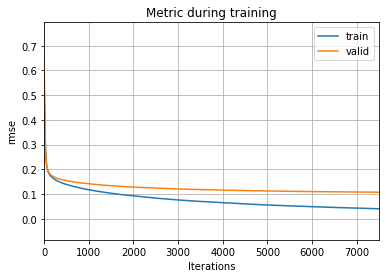

Plotting feature importances...


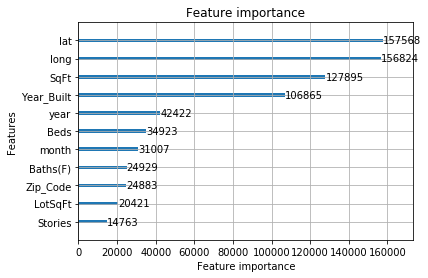

In [12]:
import matplotlib.pyplot as plt
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()

print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=20)
plt.show()

# Predicting

### Helper function:

In [13]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Load assessor's dataset:
Assessor's dataset have more properties then Sales dataset as not all properties are sold, but everyone pay the taxes.

In [32]:
assess_path = r'C:\SFSU\Spring 2020\Project\Data\assessor\Historic_Secured_Property_Tax_Rolls_Processed.csv'
assess_out = pd.read_csv(assess_path)

In [33]:
assess_out

,Unnamed: 0,address,number_street_type,long,lat,Closed Roll Fiscal Year,Property Location,Neighborhood Code Definition,Block and Lot Number,Property Class Code Definition,...,Lot Area,Prior Sales Date,Recordation Date,Current Sales Date,Closed Roll Assessed Fixtures Value,Closed Roll Assessed Improvement Value,Closed Roll Assessed Land Value,Closed Roll Assessed Personal Prop Value,Zipcode of Parcel,Location
0,0,1114 1108 CHURCH ST0000,1108 CHURCH ST,-122.427855,37.753051,2008.0,1114 1108 CHURCH ST0000,Noe Valley,3651002,Apartment,...,2622.0,NaN,07/17/1970,NaN,0.0,65944.0,45891.0,0.0,94114.0,"(37.7530509295886, -122.427855211117)"
1,1,1114 1108 CHURCH ST0000,1108 CHURCH ST,-122.427855,37.753051,2007.0,1114 1108 CHURCH ST0000,Noe Valley,3651002,Apartment,...,2622.0,NaN,07/17/1970,NaN,0.0,64651.0,44992.0,0.0,94114.0,"(37.7530509295886, -122.427855211117)"
2,2,1114 1108 CHURCH ST0000,1108 CHURCH ST,-122.427855,37.753051,2010.0,1114 1108 CHURCH ST0000,Noe Valley,3651002,Apartment,...,2622.0,NaN,07/17/1970,NaN,0.0,67103.0,46697.0,0.0,94114.0,"(37.7530509295886, -122.427855211117)"
3,3,1114 1108 CHURCH ST0000,1108 CHURCH ST,-122.427855,37.753051,2011.0,1114 1108 CHURCH ST0000,Noe Valley,3651002,Apartment,...,2622.0,NaN,07/17/1970,NaN,0.0,67607.0,47048.0,0.0,94114.0,"(37.7530509295886, -122.427855211117)"
4,4,1114 1108 CHURCH ST0000,1108 CHURCH ST,-122.427855,37.753051,2009.0,1114 1108 CHURCH ST0000,Noe Valley,3651002,Apartment,...,2622.0,NaN,07/17/1970,NaN,0.0,67262.0,46808.0,0.0,94114.0,"(37.7530509295886, -122.427855211117)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497936,1497936,0000 0270 SUMMIT WY0000,270 SUMMIT WAY,-122.477485,37.714931,2014.0,0000 0270 SUMMIT WY0000,Stonestown,7331064,Vacant Lot,...,2200.0,NaN,02/20/2013,NaN,0.0,0.0,0.0,0.0,94132.0,"(37.7149305023685, -122.477485144071)"
1497937,1497937,0000 1320 POTRERO AV0000,1320 POTRERO AVE,-122.406370,37.750866,2014.0,0000 1320 POTRERO AV0000,Inner ission,4276044,Industrial,...,3671.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,94110.0,"(37.7508961815579, -122.406506976489)"
1497938,1497938,0060 0060 IRIS AV0000,60 IRIS AVE,-122.451814,37.784853,2014.0,0060 0060 IRIS AV0000,Jordan Park/Laurel Heights,1043042,Condominium,...,0.0,NaN,11/25/2014,NaN,0.0,0.0,0.0,0.0,94118.0,"(37.7848547745724, -122.45171185778)"
1497939,1497939,0000 1528 15TH ST0000,1528 15TH ST,-122.418308,37.766866,2014.0,0000 1528 15TH ST0000,Inner ission,3548021,NaN,...,2077.0,NaN,10/01/2013,10/01/2013,0.0,337725.0,788025.0,0.0,94103.0,"(37.7669648974234, -122.41831657763)"


In [15]:
sales_columns = ['Beds',
                'Baths(F)',
                'SqFt',
                'LotSqFt',
                'Year Built',
                'Zip Code',
                'Stories',
                'long',
                'lat']

In [16]:
assess_columns = ['Number of Bedrooms',
                'Number of Bathrooms',
                'Property Area in Square Feet',
                'Lot Area',
                'Year Property Built',
                'Zipcode of Parcel',
                'Number of Stories',
                'long',
                'lat']

In [17]:
assess_out = assess_out[assess_columns]
assess_out.columns = sales_columns
assess_out.drop_duplicates(inplace=True)

In [18]:
# Drop addresses without Bedrooms as they mostly correspond to non residential buildings:
assess_out = assess_out[assess_out.Beds>0]

In [19]:
# Create fictional sale date:
assess_out['month']=1
assess_out['year']=1993

In [21]:
# Predict the monthly prices for all available properties starting with 1993:
preds = []
for y in tqdm(range(2020-1993)):
    for m in range(12):
        pred_df = assess_out.copy()
        pred_df.month = pred_df.month + m
        pred_df.year = pred_df.year + y
        preds += [np.exp(gbm.predict(pred_df)).astype(np.int32)]


100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [2:29:30<00:00, 332.25s/it]


In [43]:
import gc
gc.collect()

119

In [36]:
# Predictions to dataframe in one go:
pred_df = pd.DataFrame(preds)

In [37]:
# Calculate monthly price difference for every property:
pred_df = pred_df.pct_change().iloc[1:,:]

In [41]:
pred_df = pred_df*12*10

In [42]:
# Cancat with the assessors data:
pred_df = pred_df.T
pred_df.set_index(assess_out.index, inplace = True)
pred_df = pd.concat([assess_out, pred_df], axis=1)

# From wide to long form:
cols = assess_out.columns
val_cols = list(set(pred_df.columns)-set(cols))
pred_df = pd.melt(pred_df, id_vars=cols, value_vars=val_cols)

# Create datetime column:
pred_df['day'] = 1
pred_df['date'] = pd.to_datetime(pred_df[['year','month','day']])
pred_df['date'] = pred_df['date'] + pred_df['variable'].values.astype("timedelta64[M]")
pred_df.date = pred_df.date.apply(lambda x:x.replace(hour=1, minute=0, second=0))
#pred_df.date = pred_df.date + pd.Timedelta(hours=1)

# Drop properties that were built before sold: :)
pred_df = pred_df[pred_df['Year Built']<= pred_df.year]
pred_df.drop(columns=['day','month','year','variable'], inplace=True)

MemoryError: 

In [ ]:
pred_path = r'C:\SFSU\Spring 2020\Project\Data\assessor\pred_tmp_3mnth.csv'
pred_df.to_csv(pred_path)

In [12]:
pred_path = r'C:\SFSU\Spring 2020\Project\Data\assessor\pred_tmp_3mnth.csv'
pred_df = pd.read_csv(pred_path)

In [15]:
pred_df = pred_df.iloc[:,1:]
pred_df['value']= pred_df.value*12*100
pred_df.head()

,Beds,Baths(F),SqFt,LotSqFt,Year Built,Zip Code,Stories,long,lat,value,date
0,3,2.0,2045,0.0,1931.0,94123.0,2,-122.434989,37.804396,297.175807,1993-01-31 01:00:00
1,2,2.0,1255,960.0,1992.0,94124.0,1,-122.382875,37.737902,46.620467,1993-01-31 01:00:00
2,1,1.0,769,0.0,1907.0,94102.0,7,-122.408823,37.783768,319.985728,1993-01-31 01:00:00
3,4,4.0,4000,3000.0,1912.0,94118.0,2,-122.466806,37.778727,67.496598,1993-01-31 01:00:00
4,2,2.0,1440,0.0,1900.0,94110.0,1,-122.414316,37.752814,262.304181,1993-01-31 01:00:00


In [27]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16644190 entries, 0 to 16644189
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Beds        int64  
 1   Baths(F)    float64
 2   SqFt        int64  
 3   LotSqFt     float64
 4   Year Built  float64
 5   Zip Code    float64
 6   Stories     int64  
 7   long        float64
 8   lat         float64
 9   value       float64
 10  date        object 
dtypes: float64(7), int64(3), object(1)
memory usage: 1.4+ GB


In [16]:
# Create datetime column:
sales_out2['day'] = 1
sales_out2['date'] = pd.to_datetime(sales_out2[['year','month','day']])
sales_out2['date'] = sales_out2.date.apply(lambda x:x.replace(hour=1, minute=0, second=0))
#pred_df.date = pred_df.date + pd.Timedelta(hours=1)
sales_out2.drop(columns=['day','month','year'], inplace=True)
sales_out2.head()

,long,lat,Beds,Baths(F),SqFt,LotSqFt,Sale Price,Stories,Year Built,Zip Code,date
1,-122.457174,37.729578,3.0,3.0,2375.0,6686.0,625000.0,NaN,1920.0,94112.0,1998-10-01 01:00:00
2,-122.457174,37.729578,3.0,3.0,2375.0,0.0,625000.0,1.0,1920.0,94112.0,1998-10-01 01:00:00
3,-122.457174,37.729578,3.0,2.0,2375.0,0.0,1318899.0,2.0,1920.0,94112.0,2011-10-01 01:00:00
4,-122.393159,37.721722,1.0,1.0,590.0,0.0,85000.0,NaN,1924.0,94124.0,1998-11-01 01:00:00
5,-122.393159,37.721722,5.0,3.0,1502.0,2500.0,820000.0,NaN,1924.0,94124.0,2018-08-01 01:00:00


In [23]:
test_df = pd.concat([pred_df, sales_out2])
test_df.head()

,Beds,Baths(F),SqFt,LotSqFt,Year Built,Zip Code,Stories,long,lat,value,date,Sale Price
0,3.0,2.0,2045.0,0.0,1931.0,94123.0,2.0,-122.434989,37.804396,297.175807,1993-01-31 01:00:00,NaN
1,2.0,2.0,1255.0,960.0,1992.0,94124.0,1.0,-122.382875,37.737902,46.620467,1993-01-31 01:00:00,NaN
2,1.0,1.0,769.0,0.0,1907.0,94102.0,7.0,-122.408823,37.783768,319.985728,1993-01-31 01:00:00,NaN
3,4.0,4.0,4000.0,3000.0,1912.0,94118.0,2.0,-122.466806,37.778727,67.496598,1993-01-31 01:00:00,NaN
4,2.0,2.0,1440.0,0.0,1900.0,94110.0,1.0,-122.414316,37.752814,262.304181,1993-01-31 01:00:00,NaN


In [28]:
test_df

,Beds,Baths(F),SqFt,LotSqFt,Year Built,Zip Code,Stories,long,lat,value,date,Sale Price
0,3.0,2.0,2045.0,0.0,1931.0,94123.0,2.0,-122.434989,37.804396,297.175807,1993-01-31 01:00:00,NaN
1,2.0,2.0,1255.0,960.0,1992.0,94124.0,1.0,-122.382875,37.737902,46.620467,1993-01-31 01:00:00,NaN
2,1.0,1.0,769.0,0.0,1907.0,94102.0,7.0,-122.408823,37.783768,319.985728,1993-01-31 01:00:00,NaN
3,4.0,4.0,4000.0,3000.0,1912.0,94118.0,2.0,-122.466806,37.778727,67.496598,1993-01-31 01:00:00,NaN
4,2.0,2.0,1440.0,0.0,1900.0,94110.0,1.0,-122.414316,37.752814,262.304181,1993-01-31 01:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
185843,4.0,4.0,5580.0,4708.0,1917.0,94123.0,NaN,-122.444845,37.794469,NaN,2019-10-01 01:00:00,7750000.0
185844,4.0,3.0,4300.0,5427.0,0.0,94123.0,NaN,-122.442762,37.793966,NaN,2019-10-01 01:00:00,8500000.0
185845,5.0,5.0,4822.0,0.0,0.0,94114.0,NaN,-122.429361,37.756961,NaN,2019-07-01 01:00:00,8700000.0
185846,5.0,3.0,5469.0,5105.0,1900.0,94115.0,NaN,-122.435252,37.791208,NaN,2019-09-01 01:00:00,9150000.0


In [24]:
test_df.loc[test_df['Beds']>6,'Beds']=7

In [25]:
test_path = r'C:\SFSU\Spring 2020\Project\Data\assessor\test_df_3mnth_pct.csv'
test_df[['Beds','long','lat','value','Sale Price','date']].sample(frac=0.05, replace=False, random_state=1).to_csv(test_path, index=False)

In [31]:
assess_out

NameError: name 'assess_out' is not defined